In [2]:
import json 
import numpy as np 
import pandas as pd 

In [3]:
pwd

'/Users/taesoodaniellee/Documents/heaviside/multiclass_src/notebooks'

# Analyzing 

In [4]:
results_path = "/Users/taesoodaniellee/Documents/heaviside/multiclass_src/results"
output_file = "cifar_results.json"
fp = "/".join([results_path, output_file])
with open(fp, "r+") as f: 
    results = json.load(f)
    print(len(results))

376


In [5]:
run_list = [x['run_name'] for x in results if 'run_name' in x]

In [6]:
def extract_runs_from_json(results_json, runs_array): 
    extract = [x for x in results_json if x['run_name'] in runs_array]
    return extract

In [7]:
def aggregate_runs(results_json): 
    '''Assuming each input is an array of JSONs that all have the same shape'''
    agg = {}
    agg["run"] = '-'.join(results_json[0]['run_name'].split('-')[:-1])
    agg['loss'] = np.mean([x['loss'] for x in results_json])
    agg['test_wt_f1_score'] = np.mean([x['test_wt_f1_score'] for x in results_json])
    agg['val_wt_f1_score'] = np.mean([x['val_wt_f1_score'] for x in results_json])
    agg['test_accuracy'] = np.mean([x['test_accuracy'] for x in results_json])
    agg['val_accuracy'] = np.mean([x['val_accuracy'] for x in results_json])
    agg['loss_metric'] = results_json[0]['loss_metric']
    
    # adding in distributions. 
    train_dxns = [x['train_dxn'] for x in results_json]
    agg['train_dxn'] = np.mean(train_dxns, axis=0)
    test_dxns = [x['test_dxn'] for x in results_json]
    agg['test_dxn'] = np.mean(test_dxns, axis=0)
    valid_dxns = [x['valid_dxn'] for x in results_json]
    agg['valid_dxn'] = np.mean(valid_dxns, axis=0)
    
    # adding in evaluation results. 
    # keep in mind that the evaluation distribution is evenly weighted. 
    eval_json = {}
    taus = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
    for tau in taus: 
        eval_json[str(tau)] = {}
        eval_json[str(tau)]['mean_f1'] =  np.mean([x['evaluation'][str(tau)]['mean_f1'] for x in results_json])
        class_f1s = [x['evaluation'][str(tau)]['class_f1s'] for x in results_json]
        eval_json[str(tau)]['class_f1s'] = np.mean(class_f1s, axis=0)
    agg['eval'] = eval_json
    
    return agg 

In [8]:
def show_valid_dxn(agg): 
    heights = agg['valid_dxn']
    classes = [x for x in range(1,11)]
    plt.ylim(min(heights)-100, max(heights)+100)
    plt.bar(classes, heights)
    plt.xlabel("Classes")
    plt.ylabel("Observations")
    plt.title("Valid Distribution across Classes")
    plt.grid()
    plt.show()
def show_train_dxn(agg):
    heights = agg['train_dxn']
    classes = [x for x in range(1,11)]
    plt.ylim(min(heights)-1000, max(heights)+1000)
    plt.xlabel("Classes")
    plt.ylabel("Observations")
    plt.title("Training Distribution across Classes")
    plt.bar(classes, heights)
    plt.grid()
    plt.show()

In [44]:
def comparison(baseline_agg, approx_agg): 
    classes = [x for x in range(1,11)]
    
    # Class based F1 scores from the validation set. 
    for tau in [0.1, 0.2, 0.3, 0.4, 0.45]: 
        ce_class_f1s = baseline_agg['eval'][str(tau)]['class_f1s']
        plt.plot(classes,ce_class_f1s, label="Baseline F1")

        approx_f1_class_f1s = approx_agg['eval'][str(tau)]['class_f1s']
        plt.plot(classes,approx_f1_class_f1s, label="Approx F1")

        plt.xlabel("Classes")
        plt.ylabel("F1 Scores")
        plt.title("(Eval Tau = {})".format(tau))
        plt.legend()
        plt.grid()
        plt.show()

        baseline_f1s = baseline_agg['eval'][str(tau)]['class_f1s']
        approx_f1s = approx_agg['eval'][str(tau)]['class_f1s']
        better_classes = []
        for i in range(len(approx_f1s)):
            if approx_f1s[i] > baseline_f1s[i]:
                better_classes.append(i+1)
        print("Approx Wins: Based on Eval Tau = {} -> {}".format(str(tau), better_classes))

# 1. 2048 IMB

In [10]:
# imbalanced runs 
imb_2048_approx_f1_runs = ['2048-approx-f1-imb-0', '2048-approx-f1-imb-1', '2048-approx-f1-imb-2','2048-approx-f1-imb-3',
 '2048-approx-f1-imb-4','2048-approx-f1-imb-5','2048-approx-f1-imb-6','2048-approx-f1-imb-7',
 '2048-approx-f1-imb-8','2048-approx-f1-imb-9']

imb_2048_ce_runs = ['2048-baseline-imb-0','2048-baseline-imb-1','2048-baseline-imb-2',
 '2048-baseline-imb-3','2048-baseline-imb-4','2048-baseline-imb-5','2048-baseline-imb-6',
 '2048-baseline-imb-7','2048-baseline-imb-8','2048-baseline-imb-9']

imb_2048_wt_approx_f1_runs = ['2048-approx-f1-imb-wt-0','2048-approx-f1-imb-wt-1',
 '2048-approx-f1-imb-wt-2','2048-approx-f1-imb-wt-3','2048-approx-f1-imb-wt-4',
 '2048-approx-f1-imb-wt-5','2048-approx-f1-imb-wt-6','2048-approx-f1-imb-wt-7',
 '2048-approx-f1-imb-wt-8','2048-approx-f1-imb-wt-9',]

In [11]:
imb_2048_approx_f1 = extract_runs_from_json(results, imb_2048_approx_f1_runs)
imb_2048_ce = extract_runs_from_json(results, imb_2048_ce_runs)
imb_2048_wt_approx_f1 = extract_runs_from_json(results, imb_2048_wt_approx_f1_runs)

In [12]:
imb_2048_approx_f1_agg = aggregate_runs(imb_2048_approx_f1)
imb_2048_ce_agg = aggregate_runs(imb_2048_ce)
imb_2048_wt_approx_f1_agg = aggregate_runs(imb_2048_wt_approx_f1)

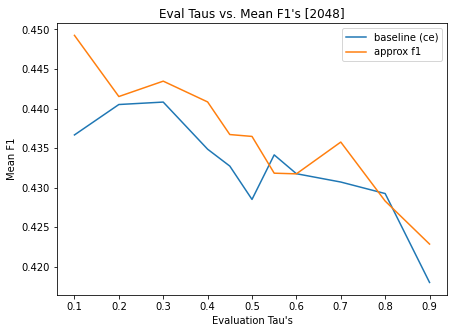

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
# plot the mean f1's across the taus 
taus = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
ce_eval_res = imb_2048_ce_agg['eval']
ce_mean_f1s = [ce_eval_res[x]['mean_f1'] for x in ce_eval_res]
plt.plot(taus, ce_mean_f1s, label="baseline (ce)")

# Comparing to imbalanced runs. 
approx_eval_res = imb_2048_approx_f1_agg['eval']
approx_f1_mean_f1s =  [approx_eval_res[x]['mean_f1'] for x in approx_eval_res]
plt.plot(taus, approx_f1_mean_f1s, label="approx f1")

plt.title("Eval Taus vs. Mean F1's [2048]")
plt.xlabel("Evaluation Tau's")
plt.ylabel("Mean F1")
plt.legend()
plt.show()

Here, we see that the approx nearly beats the baseline (ce) at almost all evaluation thresholds. 

##  Approx-F1 for 2048, IMB 

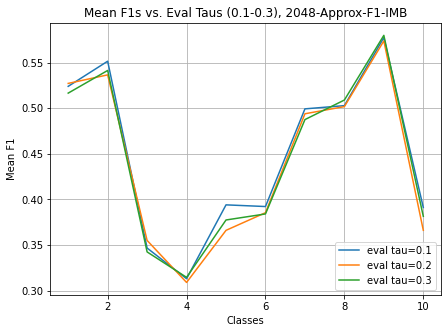

In [14]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_2048_approx_f1_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_2048_approx_f1_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_2048_approx_f1_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 2048-Approx-F1-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

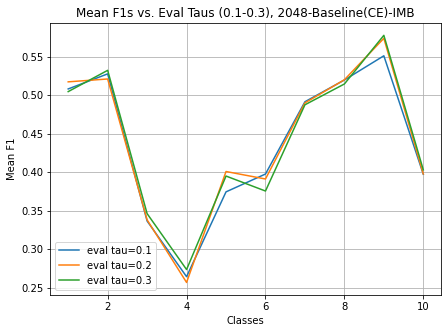

In [15]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_2048_ce_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_2048_ce_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_2048_ce_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 2048-Baseline(CE)-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

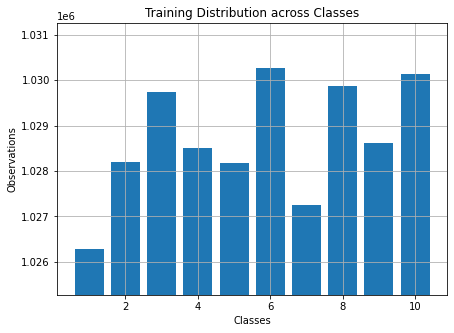

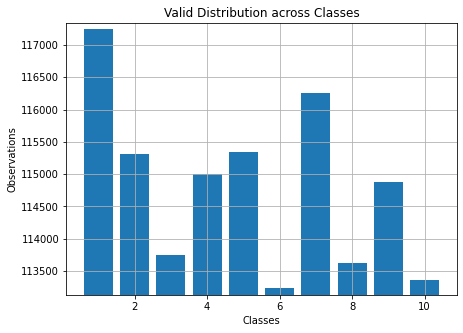

In [16]:
# Same distribution for the baseline as well
show_train_dxn(imb_2048_approx_f1_agg)
show_valid_dxn(imb_2048_approx_f1_agg)

In [17]:
print("Baseline | W-F1 Val: {}".format(imb_2048_ce_agg['val_wt_f1_score']))
print("Approx F1 | w-F1 Val: {}".format(imb_2048_approx_f1_agg['val_wt_f1_score']))

Baseline | W-F1 Val: 0.48277800000000004
Approx F1 | w-F1 Val: 0.48222899999999996


### Comparing Baseline to Approx-F1 [2048-IMB]

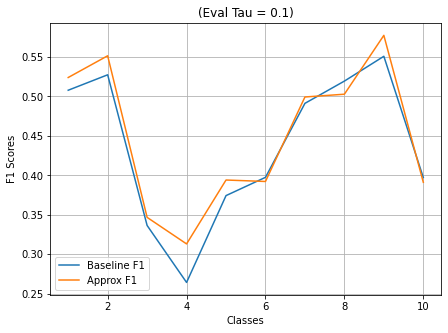

Approx Wins: Based on Eval Tau = 0.1 -> [1, 2, 3, 4, 5, 7, 9]


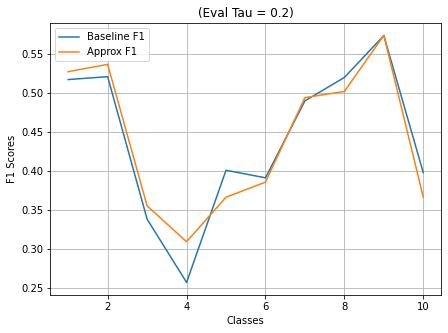

Approx Wins: Based on Eval Tau = 0.2 -> [1, 2, 3, 4, 7, 9]


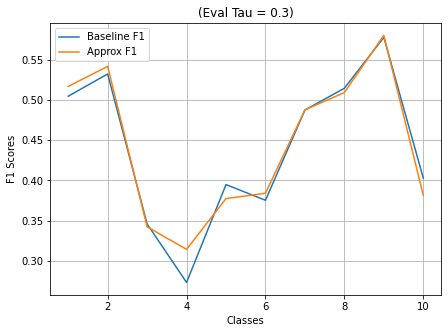

Approx Wins: Based on Eval Tau = 0.3 -> [1, 2, 4, 6, 7, 9]


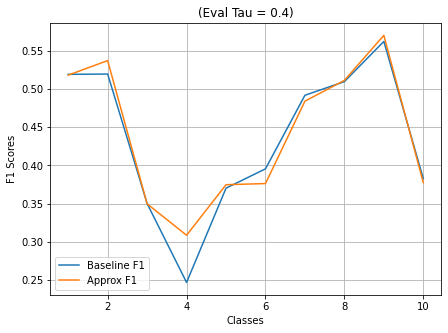

Approx Wins: Based on Eval Tau = 0.4 -> [2, 4, 5, 8, 9]


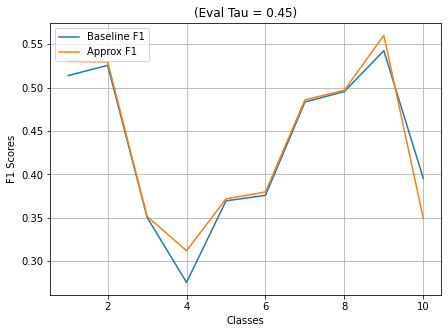

Approx Wins: Based on Eval Tau = 0.45 -> [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [45]:
comparison(baseline_agg=imb_2048_ce_agg, approx_agg=imb_2048_approx_f1_agg)

# ---------------------------------------------

# 2. 1024 IMB

In [46]:
# imbalanced 1024 
imb_1024_approx_f1_runs = ['run2-1024-approx-f1-imb-0','run2-1024-approx-f1-imb-1', 'run2-1024-approx-f1-imb-2','run2-1024-approx-f1-imb-3','run2-1024-approx-f1-imb-4',
 'run2-1024-approx-f1-imb-5','run2-1024-approx-f1-imb-6','run2-1024-approx-f1-imb-7','run2-1024-approx-f1-imb-8','run2-1024-approx-f1-imb-9']
imb_1024_ce_runs = ['run2-1024-baseline-imb-0','run2-1024-baseline-imb-1', 'run2-1024-baseline-imb-2','run2-1024-baseline-imb-3','run2-1024-baseline-imb-4',
 'run2-1024-baseline-imb-5','run2-1024-baseline-imb-6','run2-1024-baseline-imb-7','run2-1024-baseline-imb-8','run2-1024-baseline-imb-9']

In [47]:
imb_1024_approx_f1 = extract_runs_from_json(results, imb_1024_approx_f1_runs)
imb_1024_ce = extract_runs_from_json(results, imb_1024_ce_runs)

# aggregate 
imb_1024_approx_f1_agg = aggregate_runs(imb_1024_approx_f1)
imb_1024_ce_agg = aggregate_runs(imb_1024_ce)

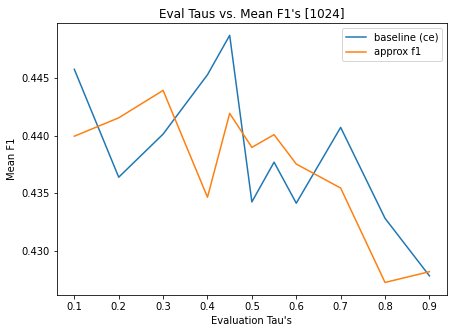

In [48]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
# plot the mean f1's across the taus 
taus = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
ce_eval_res = imb_1024_ce_agg['eval']
ce_mean_f1s = [ce_eval_res[x]['mean_f1'] for x in ce_eval_res]
plt.plot(taus, ce_mean_f1s, label="baseline (ce)")

# Comparing to imbalanced runs. 
approx_eval_res = imb_1024_approx_f1_agg['eval']
approx_f1_mean_f1s =  [approx_eval_res[x]['mean_f1'] for x in approx_eval_res]
plt.plot(taus, approx_f1_mean_f1s, label="approx f1")

plt.title("Eval Taus vs. Mean F1's [1024]")
plt.xlabel("Evaluation Tau's")
plt.ylabel("Mean F1")
plt.legend()
plt.show()

##  Approx-F1 for 1024, IMB 

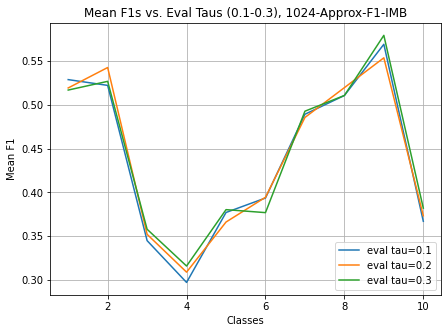

In [49]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_1024_approx_f1_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_1024_approx_f1_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_1024_approx_f1_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 1024-Approx-F1-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

##  Baseline(CE) for 1024, IMB 

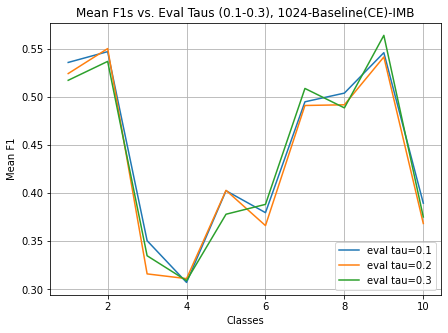

In [50]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_1024_ce_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_1024_ce_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_1024_ce_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 1024-Baseline(CE)-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

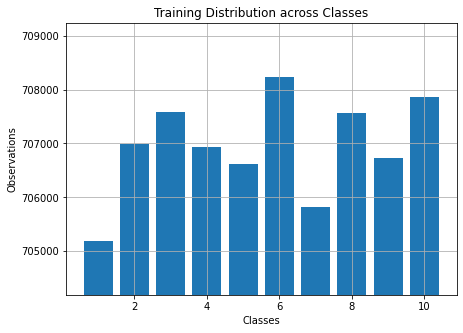

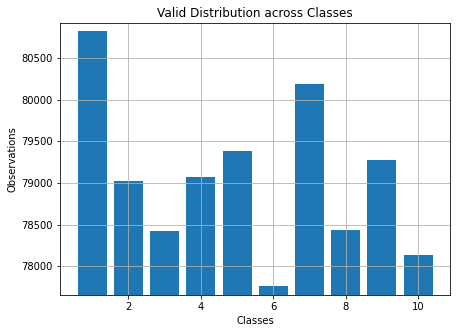

In [51]:
# Same distribution for the baseline as well
show_train_dxn(imb_1024_approx_f1_agg)
show_valid_dxn(imb_1024_approx_f1_agg)

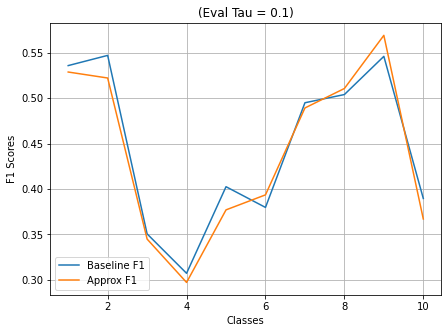

Approx Wins: Based on Eval Tau = 0.1 -> [6, 8, 9]


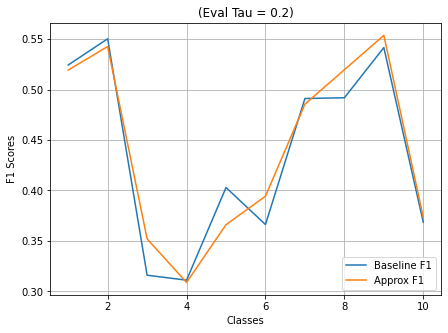

Approx Wins: Based on Eval Tau = 0.2 -> [3, 6, 8, 9, 10]


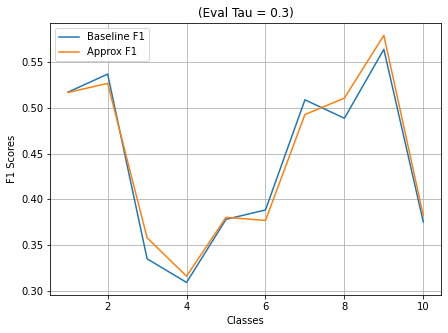

Approx Wins: Based on Eval Tau = 0.3 -> [3, 4, 5, 8, 9, 10]


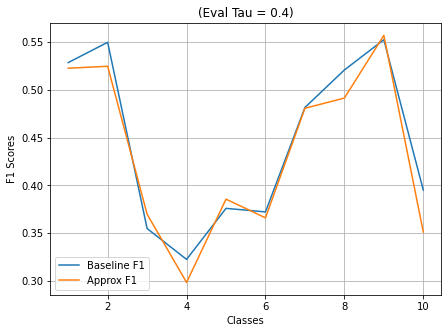

Approx Wins: Based on Eval Tau = 0.4 -> [3, 5, 9]


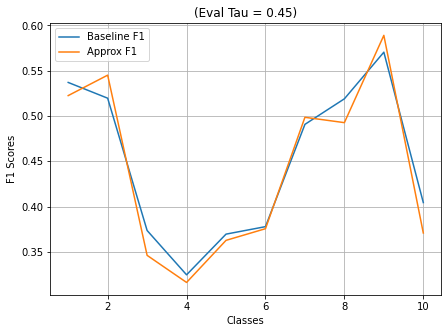

Approx Wins: Based on Eval Tau = 0.45 -> [2, 7, 9]


In [52]:
comparison(baseline_agg=imb_1024_ce_agg, approx_agg=imb_1024_approx_f1_agg)

# ------------------------------------------------------

# Run #2 for 1024 Imbalanced, Approx-F1 vs. CE 

In [53]:
# imbalanced 1024 
imb_1024_approx_f1_runs = ['run3-1024-approx-f1-imb-0','run3-1024-approx-f1-imb-1', 'run3-1024-approx-f1-imb-2',
                           'run3-1024-approx-f1-imb-3','run3-1024-approx-f1-imb-4']
imb_1024_ce_runs = ['run3-1024-baseline-ce-imb-0','run3-1024-baseline-ce-imb-1', 'run3-1024-baseline-ce-imb-2',
                    'run3-1024-baseline-ce-imb-3','run3-1024-baseline-ce-imb-4',]

joining all results with evaluation results into a larger json

In [54]:
imb_1024_approx_f1 = extract_runs_from_json(results, imb_1024_approx_f1_runs)
imb_1024_ce = extract_runs_from_json(results, imb_1024_ce_runs)

In [55]:
# aggregate 
imb_1024_approx_f1_agg = aggregate_runs(imb_1024_approx_f1)
imb_1024_ce_agg = aggregate_runs(imb_1024_ce)

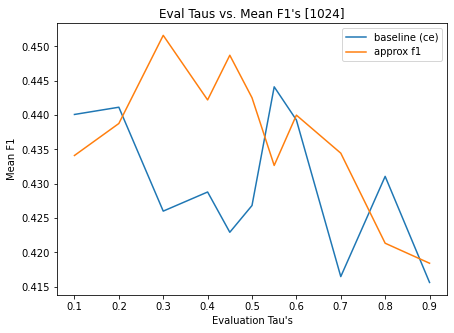

In [56]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
# plot the mean f1's across the taus 
taus = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
ce_eval_res = imb_1024_ce_agg['eval']
ce_mean_f1s = [ce_eval_res[x]['mean_f1'] for x in ce_eval_res]
plt.plot(taus, ce_mean_f1s, label="baseline (ce)")

# Comparing to imbalanced runs. 
approx_eval_res = imb_1024_approx_f1_agg['eval']
approx_f1_mean_f1s =  [approx_eval_res[x]['mean_f1'] for x in approx_eval_res]
plt.plot(taus, approx_f1_mean_f1s, label="approx f1")

plt.title("Eval Taus vs. Mean F1's [1024]")
plt.xlabel("Evaluation Tau's")
plt.ylabel("Mean F1")
plt.legend()
plt.show()

### Approx-F1 for IMB

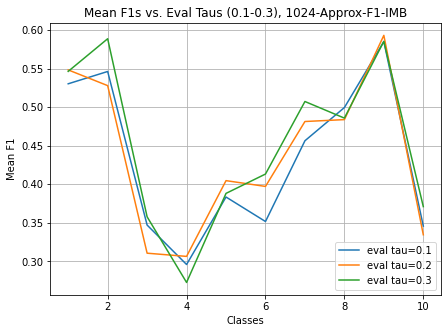

In [57]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_1024_approx_f1_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_1024_approx_f1_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_1024_approx_f1_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 1024-Approx-F1-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

### Baseline (CE) for IMB 

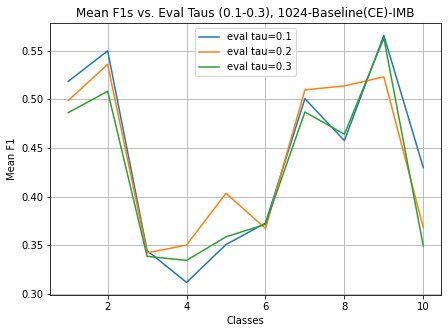

In [58]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_1024_ce_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_1024_ce_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_1024_ce_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 1024-Baseline(CE)-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

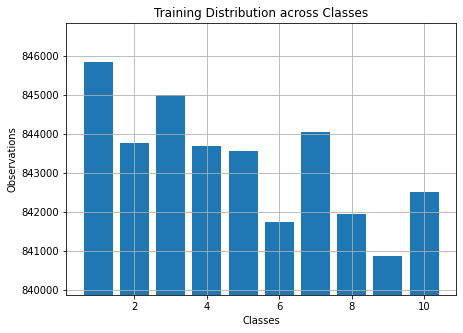

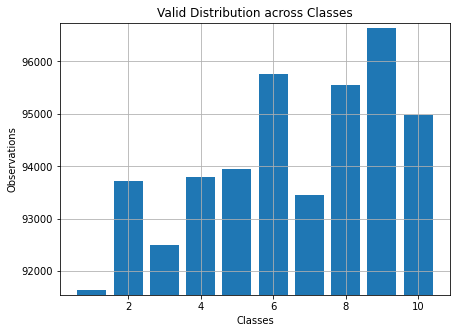

In [59]:
# Same distribution for the baseline as well
show_train_dxn(imb_1024_approx_f1_agg)
show_valid_dxn(imb_1024_approx_f1_agg)

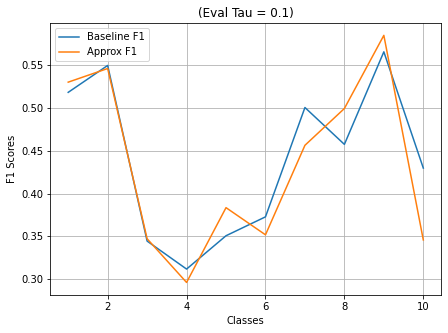

Approx Wins: Based on Eval Tau = 0.1 -> [1, 3, 5, 8, 9]


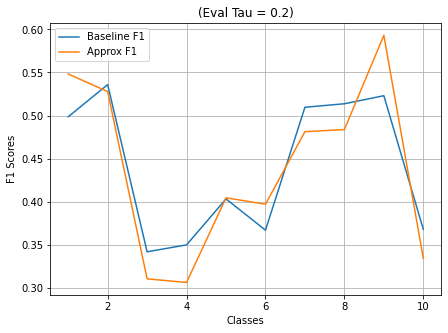

Approx Wins: Based on Eval Tau = 0.2 -> [1, 5, 6, 9]


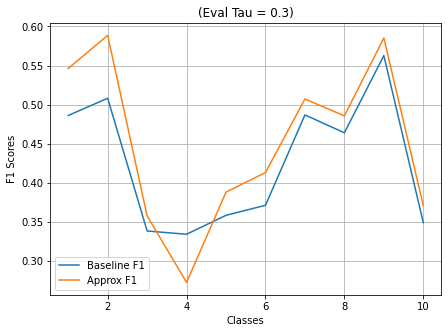

Approx Wins: Based on Eval Tau = 0.3 -> [1, 2, 3, 5, 6, 7, 8, 9, 10]


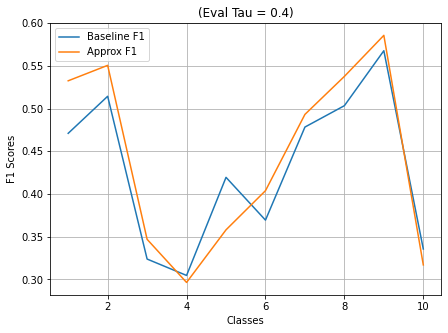

Approx Wins: Based on Eval Tau = 0.4 -> [1, 2, 3, 6, 7, 8, 9]


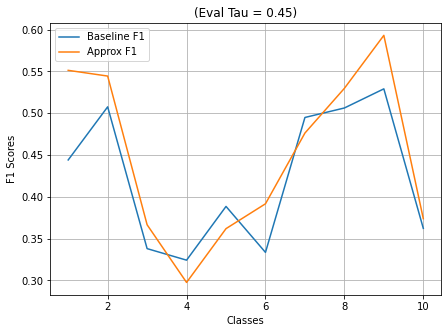

Approx Wins: Based on Eval Tau = 0.45 -> [1, 2, 3, 6, 8, 9, 10]


In [60]:
comparison(baseline_agg=imb_1024_ce_agg, approx_agg=imb_1024_approx_f1_agg)

# ------------------------------------------------------

# 3. 512

In [61]:
imb_512_approx_f1_runs = ['512-approx-f1-imb-0',
 '512-approx-f1-imb-0','512-approx-f1-imb-1','512-approx-f1-imb-1',
 '512-approx-f1-imb-2','512-approx-f1-imb-2','512-approx-f1-imb-3',
 '512-approx-f1-imb-3','512-approx-f1-imb-4',
 '512-approx-f1-imb-4','512-approx-f1-imb-5','512-approx-f1-imb-6',
 '512-approx-f1-imb-7','512-approx-f1-imb-8','512-approx-f1-imb-9']

imb_512_ce_runs = [ '512-baseline-ce-imb-0','512-baseline-ce-imb-1','512-baseline-ce-imb-2',
 '512-baseline-ce-imb-3','512-baseline-ce-imb-4','512-baseline-ce-imb-5',
 '512-baseline-ce-imb-6','512-baseline-ce-imb-7','512-baseline-ce-imb-8','512-baseline-ce-imb-9'] 

In [62]:
imb_512_approx_f1 = extract_runs_from_json(results, imb_512_approx_f1_runs)
imb_512_ce = extract_runs_from_json(results, imb_512_ce_runs)

# aggregate 
imb_512_approx_f1_agg = aggregate_runs(imb_512_approx_f1)
imb_512_ce_agg = aggregate_runs(imb_512_ce)

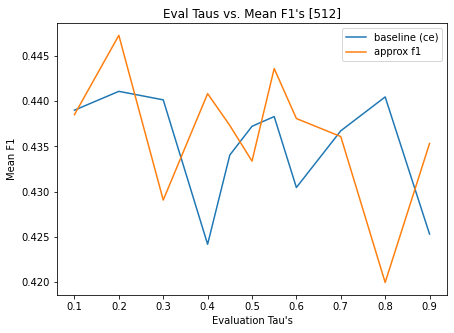

In [63]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
# plot the mean f1's across the taus 
taus = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
ce_eval_res = imb_512_ce_agg['eval']
ce_mean_f1s = [ce_eval_res[x]['mean_f1'] for x in ce_eval_res]
plt.plot(taus, ce_mean_f1s, label="baseline (ce)")

# Comparing to imbalanced runs. 
approx_eval_res = imb_512_approx_f1_agg['eval']
approx_f1_mean_f1s =  [approx_eval_res[x]['mean_f1'] for x in approx_eval_res]
plt.plot(taus, approx_f1_mean_f1s, label="approx f1")

plt.title("Eval Taus vs. Mean F1's [512]")
plt.xlabel("Evaluation Tau's")
plt.ylabel("Mean F1")
plt.legend()
plt.show()

# Take this model, run the evaluation (for each evaluation)
# Find the best training class for each tau


## Approx-F1 for 512, IMB 

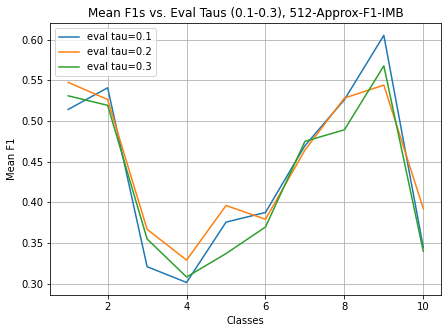

In [65]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_512_approx_f1_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_512_approx_f1_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_512_approx_f1_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 512-Approx-F1-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

## Baseline (CE) for 512, IMB

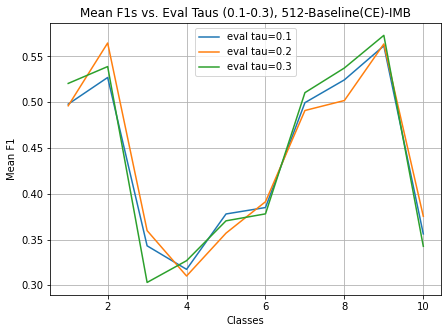

In [66]:
# Plotting for Class 0.1 
classes = [x for x in range(1,11)]
class_0_1_f1s = imb_512_ce_agg['eval']['0.1']['class_f1s']
plt.plot(classes,class_0_1_f1s, label="eval tau=0.1")
class_0_2_f1s = imb_512_ce_agg['eval']['0.2']['class_f1s']
plt.plot(classes,class_0_2_f1s, label="eval tau=0.2")
class_0_3_f1s = imb_512_ce_agg['eval']['0.3']['class_f1s']
plt.plot(classes,class_0_3_f1s, label="eval tau=0.3")

plt.title("Mean F1s vs. Eval Taus (0.1-0.3), 512-Baseline(CE)-IMB")
plt.xlabel("Classes")
plt.ylabel("Mean F1")
plt.grid()
plt.legend()
plt.show()

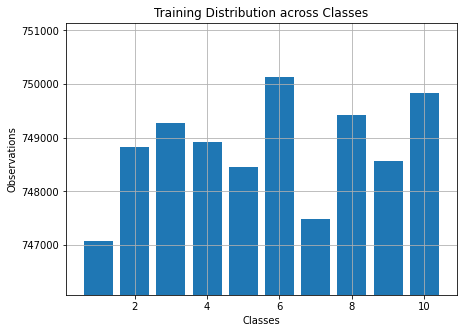

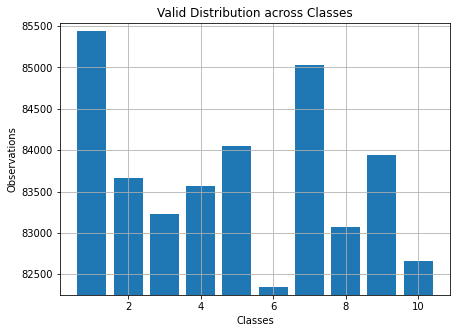

In [67]:
show_train_dxn(imb_512_approx_f1_agg)
show_valid_dxn(imb_512_approx_f1_agg)

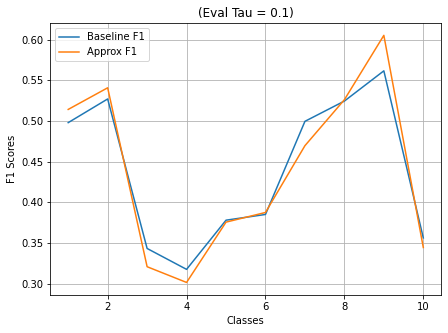

Approx Wins: Based on Eval Tau = 0.1 -> [1, 2, 6, 8, 9]


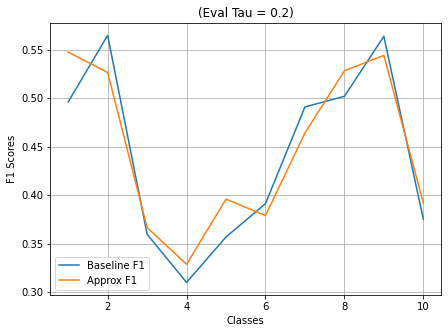

Approx Wins: Based on Eval Tau = 0.2 -> [1, 3, 4, 5, 8, 10]


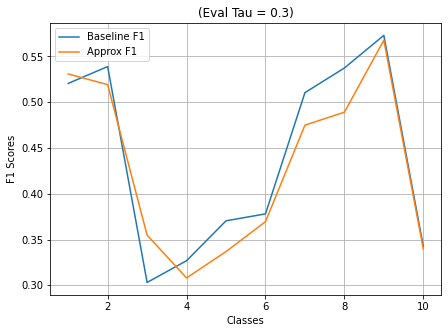

Approx Wins: Based on Eval Tau = 0.3 -> [1, 3]


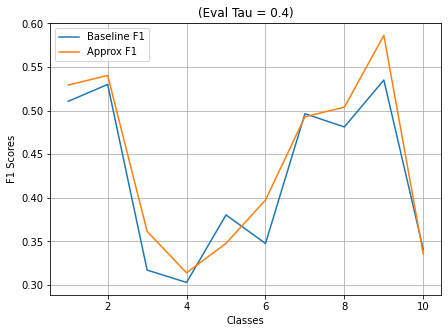

Approx Wins: Based on Eval Tau = 0.4 -> [1, 2, 3, 4, 6, 8, 9]


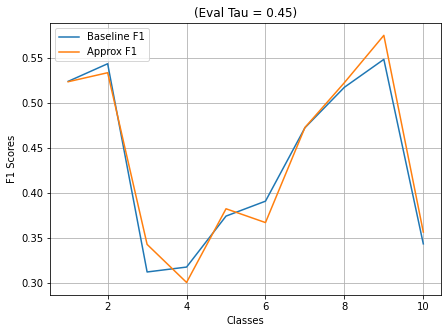

Approx Wins: Based on Eval Tau = 0.45 -> [3, 5, 7, 8, 9, 10]


In [69]:
comparison(baseline_agg=imb_512_ce_agg, approx_agg=imb_512_approx_f1_agg)